Performs the EOF analysis on the reconstruction time series

In [2]:
from dask.distributed import Client
client = Client()
client

/home/lmjong/miniconda3/envs/SST_reco/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36173 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:36173/status,
Dashboard: http://127.0.0.1:36173/status,Workers: 5
Total threads: 20,Total memory: 30.96 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35995,Workers: 5
Dashboard: http://127.0.0.1:36173/status,Total threads: 20
Started: Just now,Total memory: 30.96 GiB
Comm: tcp://127.0.0.1:37485,Total threads: 4
Dashboard: http://127.0.0.1:42149/status,Memory: 6.19 GiB
Nanny: tcp://127.0.0.1:45053,


In [3]:

import numpy as np
import math
import xarray as xr
from numpy import ma
import sys
import os


import matplotlib.pyplot as plt
import cartopy.crs as ccrs
plt.rcParams['font.family'] = 'Arial'
#plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

import datetime
today=datetime.date.today()

from arch.bootstrap import CircularBlockBootstrap
from arch.bootstrap import optimal_block_length
from scipy.stats import pearsonr

from scipy.ndimage import gaussian_filter
import pandas as pd


import warnings

warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings(action="ignore", message="input array is constant; the correlation coefficient is not defined")
import logging
logging.captureWarnings(True)

In [4]:
corr_coeff_smooth=xr.open_dataset('outputs/smoothed/corr_coeff_smoothed.nc')
conf_int_smooth=xr.open_dataset('outputs/smoothed/ssta_cis_smoothed.nc')
ssta_reco_smooth=xr.open_dataset('outputs/smoothed/ssta_reco_smoothed.nc')
ssta_pred_smooth=xr.open_dataset('outputs/smoothed/ssta_pred_smoothed.nc')

tvr_output=np.loadtxt('data/tvr_output.txt',skiprows=3)


In [5]:
from eofs.xarray import Eof
from eofs.tools.standard import correlation_map


lat=ssta_reco_smooth.lat.values

coslat = np.cos(np.deg2rad(lat))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(ssta_reco_smooth['ssta_reconstructed'], weights=wgts)


eof1 = solver.eofsAsCorrelation(neofs=3)

reconstructed_data = solver.reconstructedField(3)

pc1 = solver.pcs(npcs=3,pcscaling=1)
variance_fractions = solver.varianceFraction(neigs=3)
print(variance_fractions)

cumsum=np.cumsum(pc1[:,0],axis=0)
errors = solver.northTest(neigs=3)

<xarray.Dataset> Size: 130MB
Dimensions:             (lat: 89, lon: 180, time: 2027)
Coordinates:
  * lat                 (lat) float64 712B -88.0 -86.0 -84.0 ... 84.0 86.0 88.0
    lev                 float64 8B ...
  * lon                 (lon) float64 1kB 0.0 2.0 4.0 6.0 ... 354.0 356.0 358.0
  * time                (time) int64 16kB -10 -9 -8 -7 ... 2013 2014 2015 2016
Data variables:
    ssta_reconstructed  (time, lat, lon) float32 130MB ...
<xarray.DataArray 'variance_fractions' (mode: 3)> Size: 12B
array([0.78937584, 0.16926077, 0.0413634 ], dtype=float32)
Coordinates:
  * mode     (mode) int64 24B 0 1 2
Attributes:
    long_name:  variance_fractions


In [10]:
# save the files
np.savetxt('outputs/smoothed/eof1_timeseries_smooth.csv',(np.dstack((ssta_reco_smooth.time.values,pc1[:,0]))[0]))

np.savetxt('outputs/smoothed/cumsum1_smooth.csv',(np.dstack((ssta_reco_smooth.time.values,cumsum[:]))[0]))

[[-2.76710004e-01 -1.00000000e+01]
 [-7.79515862e-01 -9.00000000e+00]
 [-1.64158559e+00 -8.00000000e+00]
 ...
 [-4.27436781e+00  2.01400000e+03]
 [-2.21043968e+00  2.01500000e+03]
 [-1.10626221e-04  2.01600000e+03]]


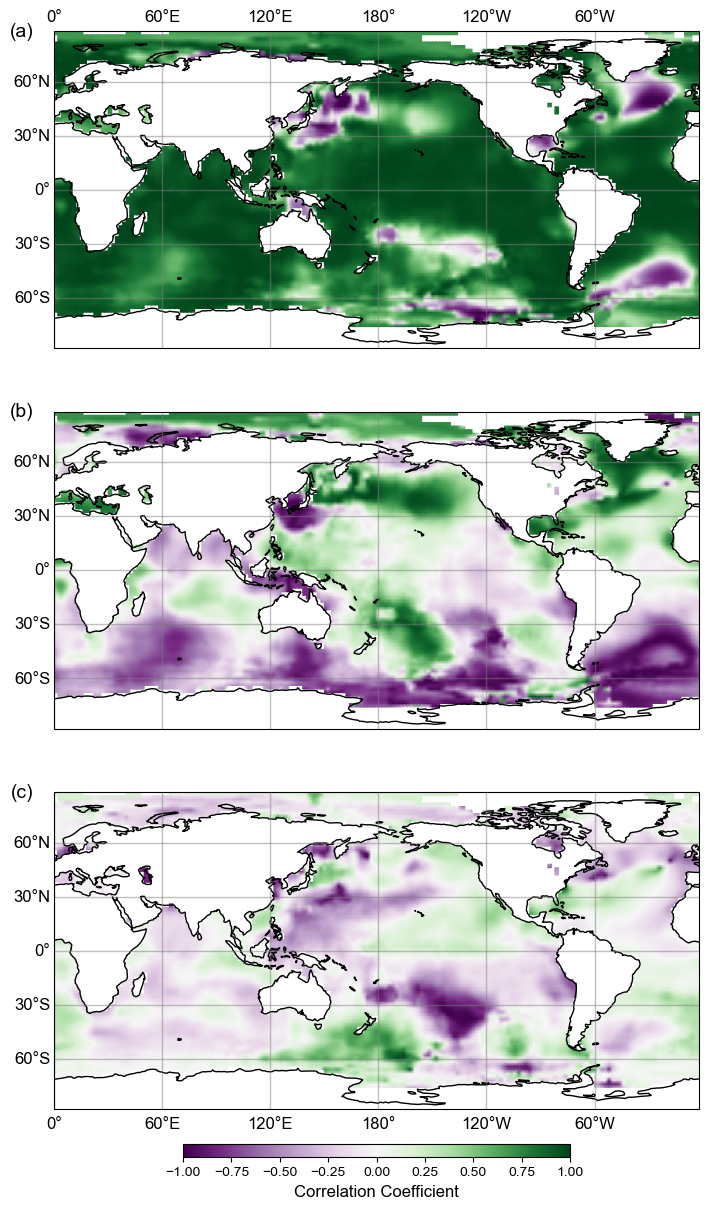

In [15]:
# This creates the plots of the first 3 EOFs in the supp info of the paper

import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LongitudeFormatter,LatitudeFormatter,LatitudeLocator
clevs = np.linspace(-1, 1,11)

proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(3, 1, subplot_kw=dict(projection=proj),figsize=[12,14])

axlabsize=14
textlabsize=12

cs0 = ax[0].pcolormesh(eof1.lon.values, eof1.lat.values, eof1[0,:,:], transform=ccrs.PlateCarree(),shading='gouraud',antialiased=True, cmap='PRGn',vmin=-1.0,vmax=1.0)

ax[0].coastlines()

gl0 = ax[0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5 )

gl0.left_labels = True
gl0.top_labels = True
gl0.bottom_labels = False


gl0.xlocator = mticker.FixedLocator([0, 60, 120, 180, -120, -60])
gl0.ylocator = LatitudeLocator()
gl0.xformatter = LongitudeFormatter()
gl0.yformatter = LatitudeFormatter()
gl0.xlabel_style = {'size': textlabsize}
gl0.ylabel_style = {'size': textlabsize}



cs1 = ax[1].pcolormesh(eof1.lon.values, eof1.lat.values, eof1[1,:,:], transform=ccrs.PlateCarree(),shading='gouraud',antialiased=True, cmap='PRGn',vmin=-1.0,vmax=1.0)

ax[1].coastlines()

gl1 = ax[1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5 )

gl1.left_labels = True
gl1.top_labels = False
gl1.bottom_labels = False


gl1.xlocator = mticker.FixedLocator([0, 60, 120, 180, -120, -60])
gl1.ylocator = LatitudeLocator()
gl1.xformatter = LongitudeFormatter()
gl1.yformatter = LatitudeFormatter()
gl1.xlabel_style = {'size': textlabsize}
gl1.ylabel_style = {'size': textlabsize}

cs2 = ax[2].pcolormesh(eof1.lon.values, eof1.lat.values, eof1[2,:,:], transform=ccrs.PlateCarree(), shading='gouraud',antialiased=True,cmap='PRGn',vmin=-1.0,vmax=1.0)
ax[2].coastlines( linewidth=1)

gl2 = ax[2].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5 )

gl2.left_labels = True
gl2.top_labels = False

gl2.xlocator = mticker.FixedLocator([0, 60, 120, 180, -120, -60])
gl2.ylocator = LatitudeLocator()
gl2.xformatter = LongitudeFormatter()
gl2.yformatter = LatitudeFormatter()
gl2.xlabel_style = {'size': textlabsize}
gl2.ylabel_style = {'size': textlabsize}

cax = ax[2].inset_axes([0.2, -0.15, 0.6, 0.04],transform = ax[2].transAxes)
cb=fig.colorbar(cs2,cax=cax,orientation='horizontal',pad=0.2,label='Correlation Coefficient')
cb.set_label(label='Correlation Coefficient',size=textlabsize)

plt.text(-0.05, 1, '(a)',
     size=axlabsize,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax[0].transAxes)

plt.text(-0.05, 1, '(b)',
     size=axlabsize,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax[1].transAxes)

plt.text(-0.05, 1, '(c)',
     size=axlabsize,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax[2].transAxes)

plt.savefig('plots/EOFs_smoothed.png'.format(today),bbox_inches="tight")
# Plot the leading PC time series.

plt.show()